# Submit a circuit with a provider-specific format to a target backend.

## 1. Pasqal

### 1.1 Create a Pasqal sequence with Pulser SDK

In [31]:
# Restart the kernel once you have run this cell
!pip install -U -q azure-quantum

try:
    import pulser
except ImportError:
    !pip -q install pulser
    !pip -q install pulser-core


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register

In [33]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype=float)
square -= np.mean(square, axis=0)
square *= 5

qubits = dict(enumerate(square))
reg = Register(qubits)

from pulser.devices import Chadoq2

input = Sequence(reg, Chadoq2)

input.declare_channel("ch0", "raman_local")
print("Available channels after declaring 'ch0':")
pprint(input.available_channels)

input.declare_channel("ch1", "rydberg_local", initial_target=4)
print("\nAvailable channels after declaring 'ch1':")
pprint(input.available_channels)

Available channels after declaring 'ch0':
{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

Available channels after declaring 'ch1':
{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),


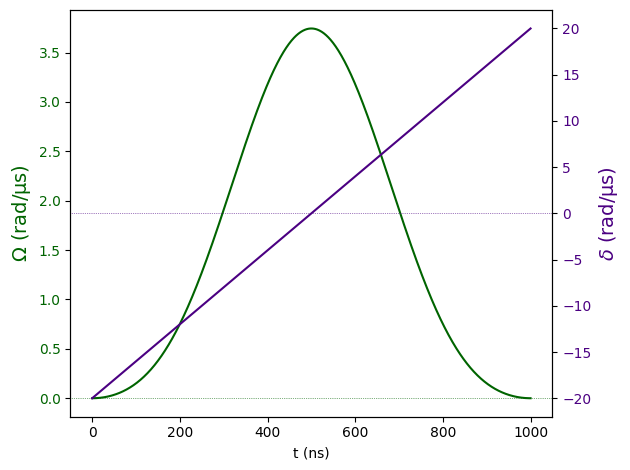

In [34]:
input.target(1, "ch0")
simple_pulse = Pulse.ConstantPulse(200, 2, -10, 0)
input.add(simple_pulse, "ch0")
input.delay(100, "ch1")
from pulser.waveforms import RampWaveform, BlackmanWaveform

duration = 1000
amp_wf = BlackmanWaveform(duration, np.pi / 2)  # Duration: 1000 ns, Area: pi/2
detuning_wf = RampWaveform(
    duration, -20, 20
)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()
input.add(complex_pulse, "ch1")

# Take the created sequence and send it to Pasqal QPU as a pass-through

In [35]:
# We connect to the Azure Quantum Workspace
from azure.quantum import Workspace
workspace = Workspace(
            resource_id = "",
            location = "")

In [36]:
import matplotlib.pyplot as plt

def plot_histogram(result):
    plt.bar(result.keys(), result.values())
    plt.xlabel('States')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    plt.show()

import json

# Convert the sequence to a JSON string
def prepare_pasqal_input_data(seq):
    input_data = {}
    input_data["sequence_builder"] = json.loads(seq.to_abstract_repr())
    to_send = json.dumps(input_data)
    #print(json.dumps(input_data, indent=4, sort_keys=True))
    return to_send

# Submit the job with proper input and output data formats
def submit_pasqal_job(target, input, name, count=100):
    job = target.submit(
        input_data=prepare_pasqal_input_data(input), 
        input_data_format="pasqal.pulser.v1", 
        output_data_format="pasqal.pulser-results.v1",
        content_type="text/plain", #application/json    
        name=name,
        input_params={
            "count": count
        }
    )

    print(f"Queued job: {job.id}")
    job.wait_until_completed()
    print(f"Job completed with state: {job.details.status}")
    result = job.get_results()

    return result

c:\Users\fabricfr\AppData\Local\Programs\Python\Python311\Lib\site-packages\pulser\register\register.py:375: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


Queued job: b2f9290b-7f4d-11ee-bcaa-0c9a3ce23dac
..........Job completed with state: Succeeded


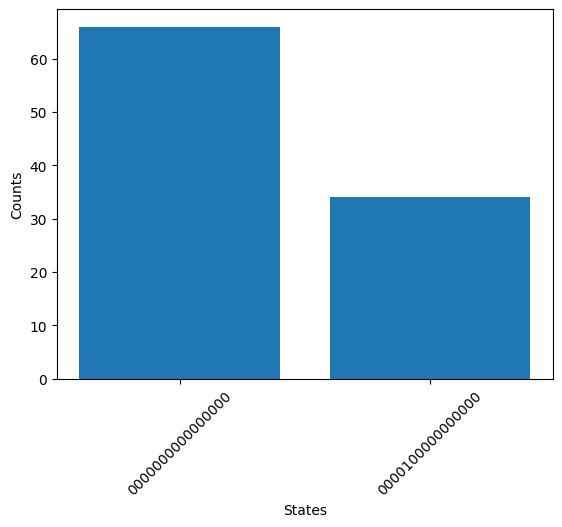

In [37]:
# Submit the job and plot the results
target = workspace.get_targets(name="pasqal.sim.emu_tn")
result = submit_pasqal_job(target, input, "Pasqal sequence")
plot_histogram(result)

## Gate-based Providers, with QIR

### 2.2 Prepare QIR input

In [38]:
# A simple entanglement circuit

QIR_routine = """%Result = type opaque
%Qubit = type opaque

define void @ENTRYPOINT__main() #0 {
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 0 to %Qubit*))
  call void @__quantum__qis__cx__body(%Qubit* inttoptr (i64 0 to %Qubit*), %Qubit* inttoptr (i64 1 to %Qubit*))
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 2 to %Qubit*))
  call void @__quantum__qis__cz__body(%Qubit* inttoptr (i64 2 to %Qubit*), %Qubit* inttoptr (i64 0 to %Qubit*))
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 2 to %Qubit*))
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 3 to %Qubit*))
  call void @__quantum__qis__cz__body(%Qubit* inttoptr (i64 3 to %Qubit*), %Qubit* inttoptr (i64 1 to %Qubit*))
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 3 to %Qubit*))
  call void @__quantum__qis__mz__body(%Qubit* inttoptr (i64 2 to %Qubit*), %Result* inttoptr (i64 0 to %Result*)) #1
  call void @__quantum__qis__mz__body(%Qubit* inttoptr (i64 3 to %Qubit*), %Result* inttoptr (i64 1 to %Result*)) #1
  call void @__quantum__rt__tuple_record_output(i64 2, i8* null)
  call void @__quantum__rt__result_record_output(%Result* inttoptr (i64 0 to %Result*), i8* null)
  call void @__quantum__rt__result_record_output(%Result* inttoptr (i64 1 to %Result*), i8* null)
  ret void
}

declare void @__quantum__qis__ccx__body(%Qubit*, %Qubit*, %Qubit*)
declare void @__quantum__qis__cx__body(%Qubit*, %Qubit*)
declare void @__quantum__qis__cy__body(%Qubit*, %Qubit*)
declare void @__quantum__qis__cz__body(%Qubit*, %Qubit*)
declare void @__quantum__qis__rx__body(double, %Qubit*)
declare void @__quantum__qis__rxx__body(double, %Qubit*, %Qubit*)
declare void @__quantum__qis__ry__body(double, %Qubit*)
declare void @__quantum__qis__ryy__body(double, %Qubit*, %Qubit*)
declare void @__quantum__qis__rz__body(double, %Qubit*)
declare void @__quantum__qis__rzz__body(double, %Qubit*, %Qubit*)
declare void @__quantum__qis__h__body(%Qubit*)
declare void @__quantum__qis__s__body(%Qubit*)
declare void @__quantum__qis__s__adj(%Qubit*)
declare void @__quantum__qis__t__body(%Qubit*)
declare void @__quantum__qis__t__adj(%Qubit*)
declare void @__quantum__qis__x__body(%Qubit*)
declare void @__quantum__qis__y__body(%Qubit*)
declare void @__quantum__qis__z__body(%Qubit*)
declare void @__quantum__qis__swap__body(%Qubit*, %Qubit*)
declare void @__quantum__qis__mz__body(%Qubit*, %Result* writeonly) #1
declare void @__quantum__rt__result_record_output(%Result*, i8*)
declare void @__quantum__rt__array_record_output(i64, i8*)
declare void @__quantum__rt__tuple_record_output(i64, i8*)

attributes #0 = { "entry_point" "output_labeling_schema" "qir_profiles"="base_profile" "required_num_qubits"="4" "required_num_results"="2" }
attributes #1 = { "irreversible" }

; module flags

!llvm.module.flags = !{!0, !1, !2, !3}

!0 = !{i32 1, !"qir_major_version", i32 1}
!1 = !{i32 7, !"qir_minor_version", i32 0}
!2 = !{i32 1, !"dynamic_qubit_management", i1 false}
!3 = !{i32 1, !"dynamic_result_management", i1 false}
"""

### 2.3 Submit QIR input

In [43]:
# Submit the job with proper input and output data formats
def submit_qir_job(target, input, name, count=100):
    job = target.submit(
        input_data=input, 
        input_data_format="qir.v1",
        output_data_format="microsoft.quantum-results.v1",
        name=name,
        input_params = {
            "entryPoint": "ENTRYPOINT__main",
            "arguments": [],
            "count": count
            }
    )

    print(f"Queued job: {job.id}")
    job.wait_until_completed()
    print(f"Job completed with state: {job.details.status}")
    #if job.details.status == "Succeeded":
    result = job.get_results()

    return result

In [44]:
# rigetti.sim.qvm quantinuum.sim.h1-1e quantinuum.sim.h1-1sc ionq.simulator
target = workspace.get_targets(name="ionq.simulator") 
result = submit_qir_job(target, QIR_routine, "QIR routine")
result

Queued job: dc73c02a-7f4e-11ee-b267-0c9a3ce23dac
...........Job completed with state: Succeeded


{'Histogram': ['(0, 0)', 0.5, '(1, 1)', 0.5]}